# PixelSHAP: An In-Depth Usage Guide

This notebook provides a structured demonstration of how to use the `PixelSHAP` class.

In [1]:
import sys
from pathlib import Path

# Add the parent directory to the path to import token_shap modules
parent_dir = Path().resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from token_shap.base import OpenAIEmbeddings, OpenAIModel, LocalModel, HuggingFaceEmbeddings, OllamaModel, TfidfTextVectorizer
from token_shap.pixel_shap import PixelSHAP
from token_shap.image_utils import YoloSam2SegmentationModel, DinoSam2SegmentationModel, BlackoutSegmentationManipulator
from token_shap.visualization import visualize_segmentation_results

## Example with YOLO + sam2

In [2]:
from token_shap.image_utils import YoloSam2SegmentationModel

In [3]:
YOLO_MODEL_PATH = "yolov8x.pt"

segmentation_model = YoloSam2SegmentationModel(
    yolo_model_path=YOLO_MODEL_PATH,
    sam2_model_id="facebook/sam2.1-hiera-large",
    conf_threshold=0.2,
    device="cuda",
    use_yolov8=True,
)

print("✓ Segmentation model initialized with optimized settings for better coverage")

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Segmentation model initialized with optimized settings for better coverage



image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/nexar_1.png: 352x640 1 person, 5 cars, 2 trucks, 45.3ms
Speed: 3.4ms preprocess, 45.3ms inference, 75.4ms postprocess per image at shape (1, 3, 352, 640)


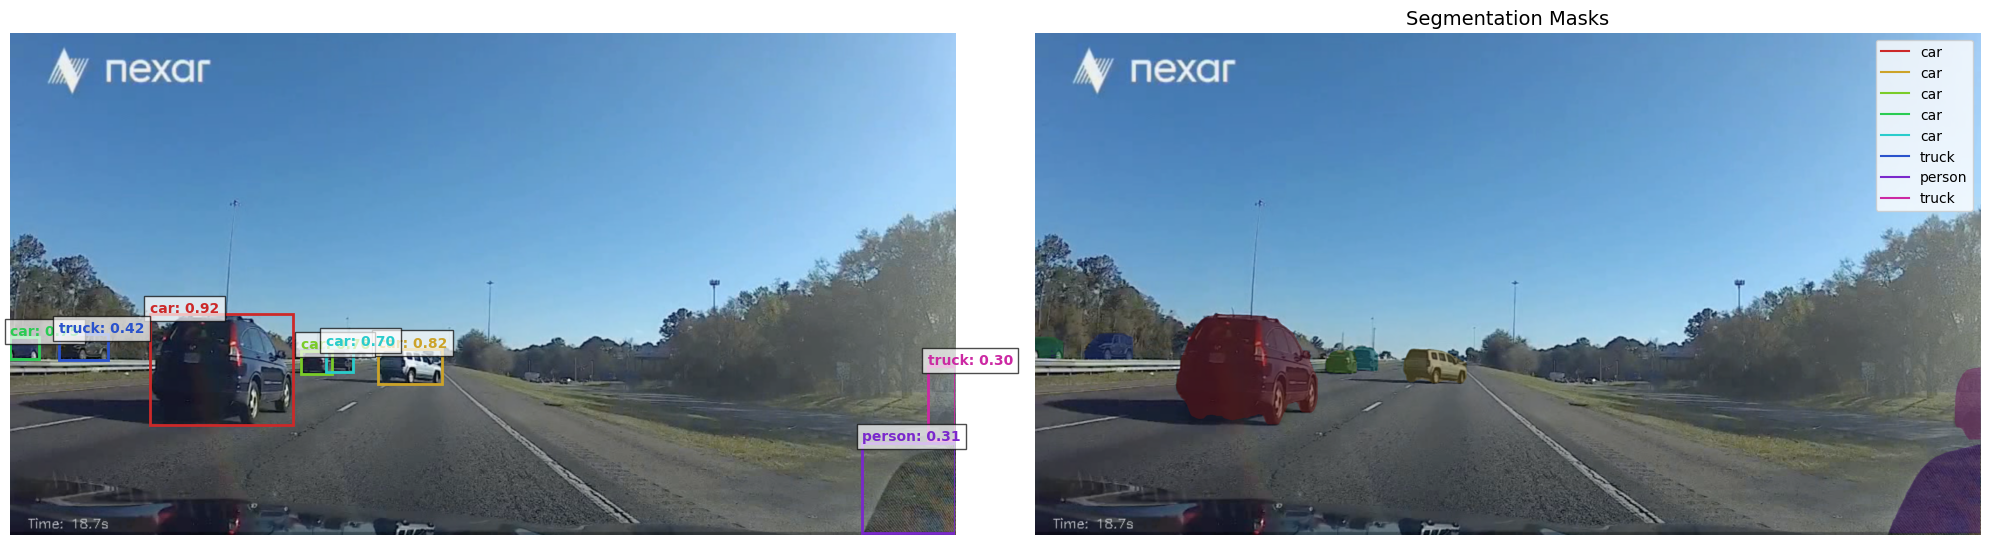

In [4]:
image_path = 'images/nexar_1.png'
boxes, labels, confidences, masks = segmentation_model.segment(image_path=image_path)
visualize_segmentation_results(image_path, boxes, labels, confidences, masks)

In [6]:
#api_key = (..)

In [7]:
vlm = OpenAIModel(
    model_name='gpt-4o',
    api_key=api_key
)
openai_embedding = OpenAIEmbeddings(
    model="text-embedding-3-large", 
    api_key=api_key
)

manipulator = BlackoutSegmentationManipulator(mask_type='bbox', preserve_overlapping=True)

In [8]:
# vlm = OllamaModel(
#     model_name='llava:latest',
#     api_url='http://35.95.163.15:11434'
# )

# openai_embedding = OpenAIEmbeddings(
#     model="text-embedding-3-small", 
#     api_key=api_key
# )

# manipulator = BlackoutSegmentationManipulator(mask_type='bbox', preserve_overlapping=True)

In [9]:
# Create PixelSHAP analyzer
pixel_shap = PixelSHAP(
    model=vlm,
    segmentation_model=segmentation_model,
    manipulator=manipulator,
    vectorizer=openai_embedding,
    debug=False,
    temp_dir='example_temp',
)

In [10]:
# Analyze image
results_df, shapley_values = pixel_shap.analyze(
    image_path=image_path,
    prompt="Which vehicle loses control?",
    sampling_ratio=0.5,
    max_combinations=20,
    cleanup_temp_files=False
)


image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/nexar_1.png: 352x640 1 person, 5 cars, 2 trucks, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing combinations:   0%|          | 0/20 [00:00<?, ?it/s]


image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/nexar_1.png: 352x640 1 person, 5 cars, 2 trucks, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


In [11]:
results_df.head()

,Combination_Key,Used_Combination,Hidden_Objects,Response,Indexes,Similarity
0,"combination_2,3,4,5,6,7,8","[car_1, car_2, car_3, car_4, truck_5, person_6...",[car_0],The white SUV in the image appears to be losin...,"(2, 3, 4, 5, 6, 7, 8)",0.893777
1,"combination_1,3,4,5,6,7,8","[car_0, car_2, car_3, car_4, truck_5, person_6...",[car_1],I can't determine which vehicle loses control ...,"(1, 3, 4, 5, 6, 7, 8)",0.681592
2,"combination_1,2,4,5,6,7,8","[car_0, car_1, car_3, car_4, truck_5, person_6...",[car_2],The white SUV in the image appears to be losin...,"(1, 2, 4, 5, 6, 7, 8)",0.893657
3,"combination_1,2,3,5,6,7,8","[car_0, car_1, car_2, car_4, truck_5, person_6...",[car_3],The white SUV in the image is the vehicle that...,"(1, 2, 3, 5, 6, 7, 8)",0.842496
4,"combination_1,2,3,4,6,7,8","[car_0, car_1, car_2, car_3, truck_5, person_6...",[car_4],"The white SUV appears to be losing control, as...","(1, 2, 3, 4, 6, 7, 8)",0.873139



image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/nexar_1.png: 352x640 1 person, 5 cars, 2 trucks, 9.3ms
Speed: 1.3ms preprocess, 9.3ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


/home/ubuntu/TokenSHAP/token_shap/visualization.py:799: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # First apply tight layout
/home/ubuntu/TokenSHAP/token_shap/visualization.py:1014: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


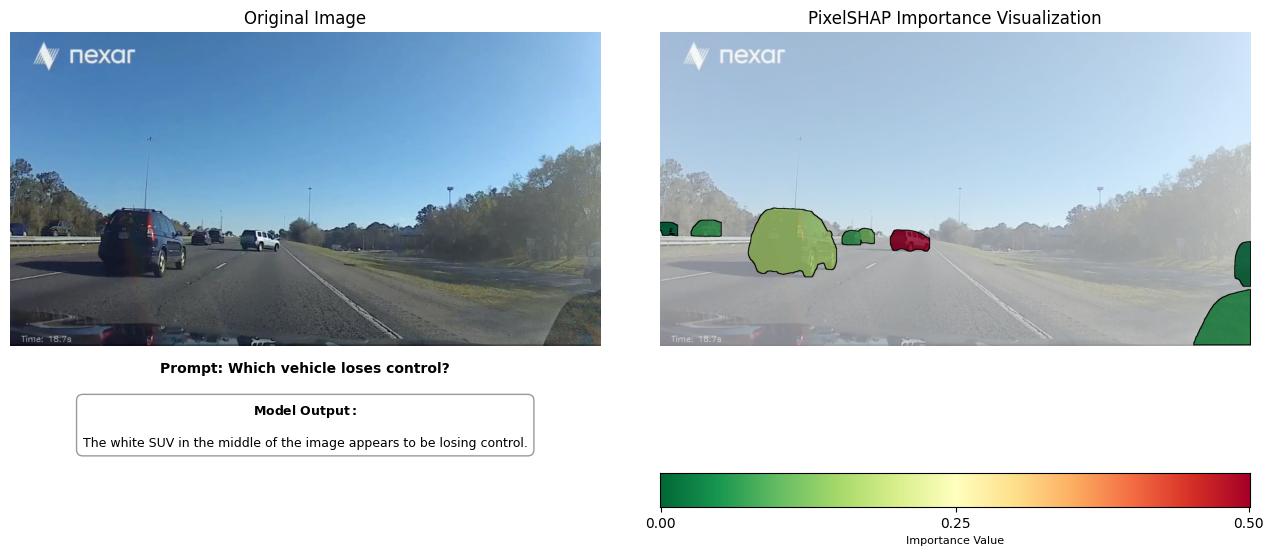

In [12]:
pixel_shap.visualize(
    background_opacity=0.5,
    show_original_side_by_side=True,
    show_labels=False,
    show_model_output=True
)


image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/nexar_1.png: 352x640 1 person, 5 cars, 2 trucks, 9.3ms
Speed: 1.4ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


/home/ubuntu/TokenSHAP/token_shap/visualization.py:298: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


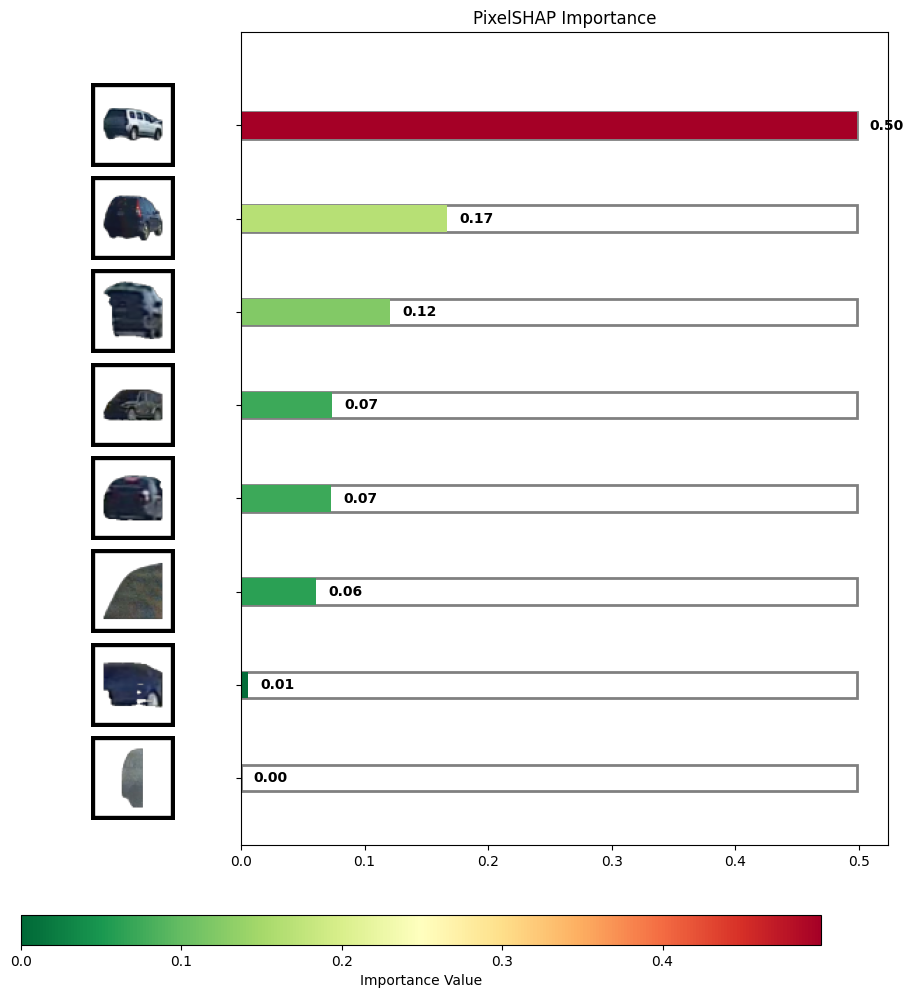

In [13]:
sorted_items = pixel_shap.plot_importance_ranking(thumbnail_size=10)

# Example with Dino + sam2

In [14]:
segmentation_model = DinoSam2SegmentationModel(
    text_prompt="cartoon character, car",
    sam2_model_id="facebook/sam2.1-hiera-large",  # Use HuggingFace SAM2 model
    grounding_dino_model="IDEA-Research/grounding-dino-tiny",  # Use HuggingFace DINO model
    device="cuda",
    box_threshold=0.35,
    text_threshold=0.3,
    # Quality parameters:
    mask_threshold=0.5,
    use_stability_score=True,
    stability_score_thresh=0.95,
    remove_small_regions=True,
    min_region_area=100,
    # Overlap resolution:
    resolve_overlaps=True,
    overlap_resolution="score"
)

TypeError: 'NoneType' object is not callable